# ミニマム DCGE モデルの実装と可視化
---
## 1. データ準備：社会会計表（SAM）の読み込み 
  - 行：金の受け手（家計、投資、輸入など）  
  - 列：金の出し手（農業、製造業など）
---

## 2. キャリブレーション：パラメータの自動計算
- **消費シェア**  
  家計が「農業」「製造業」にどれだけお金を使ったかを割合に直し、それを「家計の消費割合」として計算。  
- **投資率**  
  投資に回されたお金の合計を、経済全体が生み出した付加価値の合計で割って「投資にまわる比率」として計算。  
---

## 3. 動学シミュレーション：２０年分の推移を計算

- **初期値の設定**  
  - 作業を簡単にするため、初期の資本量や働く人数、消費と投資の割り振り割合などをあらかじめ決めておく。  
- **年ごとのループ処理**  
  １年ずつ次のように順番に計算：  
  1. 今期の「生み出された全体のモノ・サービス量（生産量）」を求める  
  2. そのうち何％を投資に回すか、何％を消費に使うかを計算  
  3. 投資分を使って翌年の資本量を更新  

In [10]:
import os, sys
# ノートブックが notebooks/ 内にある前提で、親フォルダを追加
sys.path.insert(0, os.path.abspath(".."))

In [11]:
# run_dcge.py

import os
import pandas as pd
import matplotlib.pyplot as plt

def calibrate_from_sam(sam_path):
    """
    SAM（簡易版 CSV）からベース年の消費シェア・投資率を計算して返す。
    """
    sam = pd.read_csv(sam_path, index_col=0)
    
    # 家計支出行から品目ごとの消費シェアを計算
    hh = sam.loc["Household", ["Agri", "Manu"]].astype(float)
    cons_share = (hh / hh.sum()).to_dict()
    
    # 投資行（Investment行の合計）÷総付加価値（Agri+ManuのValueAdded）
    inv_row = sam.loc["Investment", ["Agri", "Manu"]].astype(float)
    total_inv = inv_row.sum()
    va = sam.loc["ValueAdded", ["Agri", "Manu"]].astype(float).sum()
    inv_share = total_inv / va
    
    return cons_share, float(inv_share)

def simulate_dcge(cons_share, inv_share, T=20, delta=0.05, 
                  alpha=0.3, K0=100.0, L=50.0):
    """
    単純 Cobb–Douglas 技術の動学シミュレーションを行う。
    Y_t = K_t^alpha * L^(1-alpha)
    C_t = (1 - inv_share) * Y_t
    I_t = inv_share * Y_t
    K_{t+1} = (1-delta) K_t + I_t
    """
    years = list(range(T + 1))
    K_path, Y_path, C_path, I_path = [K0], [], [], []

    for t in range(T):
        K = K_path[-1]
        Y = (K**alpha) * (L ** (1 - alpha))
        I = inv_share * Y
        C = (1 - inv_share) * Y
        
        Y_path.append(Y)
        I_path.append(I)
        C_path.append(C)
        
        K_next = (1 - delta) * K + I
        K_path.append(K_next)

    # DataFrame 化
    df = pd.DataFrame({
        "Year": years[:-1],
        "Output": Y_path,
        "Consumption": C_path,
        "Investment": I_path,
        "Capital": K_path[:-1],
    })
    return df

def plot_and_save(df, outdir="../results"):
    """
    シミュレーション結果をプロットし、PNG と CSV に保存する。
    """
    os.makedirs(outdir, exist_ok=True)

    # 1) 資本ストック推移
    plt.figure(figsize=(8,5))
    plt.plot(df["Year"], df["Capital"], linewidth=3)
    plt.title("Capital Stock Path", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Capital (K)", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    cap_png = os.path.join(outdir, "capital_path.png")
    plt.savefig(cap_png, dpi=200)
    plt.close()

    # 2) 出力・消費・投資の推移
    plt.figure(figsize=(8,5))
    for col in ["Output", "Consumption", "Investment"]:
        plt.plot(df["Year"], df[col], label=col, linewidth=2)
    plt.title("Output, Consumption, Investment Dynamics", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    dyn_png = os.path.join(outdir, "dynamics.png")
    plt.savefig(dyn_png, dpi=200)
    plt.close()

    # 3) CSV 保存
    csv_path = os.path.join(outdir, "dcge_simulation.csv")
    df.to_csv(csv_path, index=False)

    print(f"Charts saved to:\n  {cap_png}\n  {dyn_png}")
    print(f"Simulation results saved to:\n  {csv_path}")

if __name__ == "__main__":
    # 1) キャリブレーション
    cons_share, inv_share = calibrate_from_sam("../data/sam_base.csv")
    print("Calibrated consumption shares:", cons_share)
    print("Calibrated investment share:", inv_share)

    # 2) シミュレーション
    df = simulate_dcge(cons_share, inv_share, T=20, delta=0.05, alpha=0.3, K0=100, L=50)

    # 3) 可視化＋保存
    plot_and_save(df, outdir="../results")


Calibrated consumption shares: {'Agri': nan, 'Manu': nan}
Calibrated investment share: 0.3
Charts saved to:
  ../results\capital_path.png
  ../results\dynamics.png
Simulation results saved to:
  ../results\dcge_simulation.csv


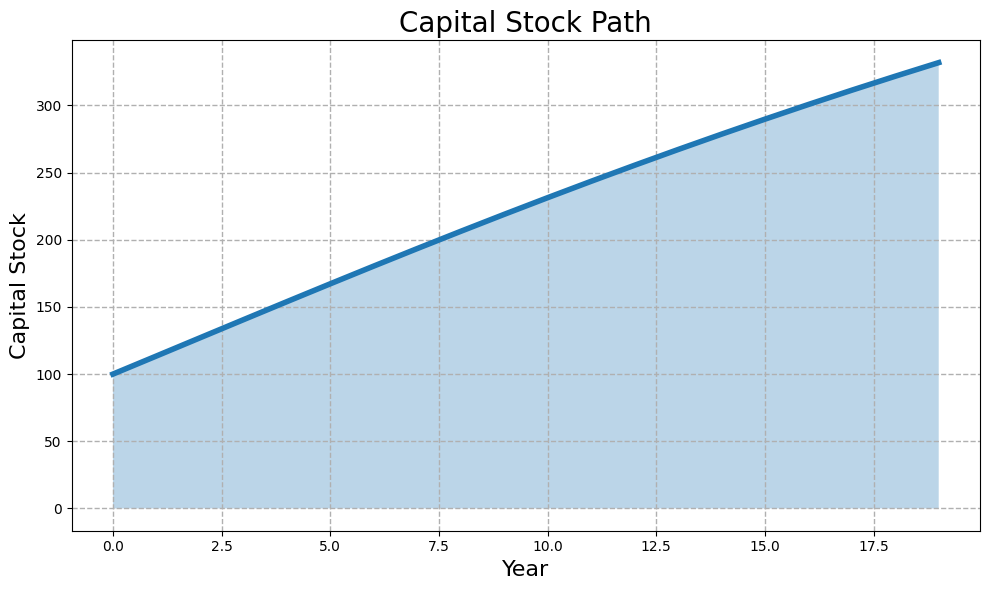

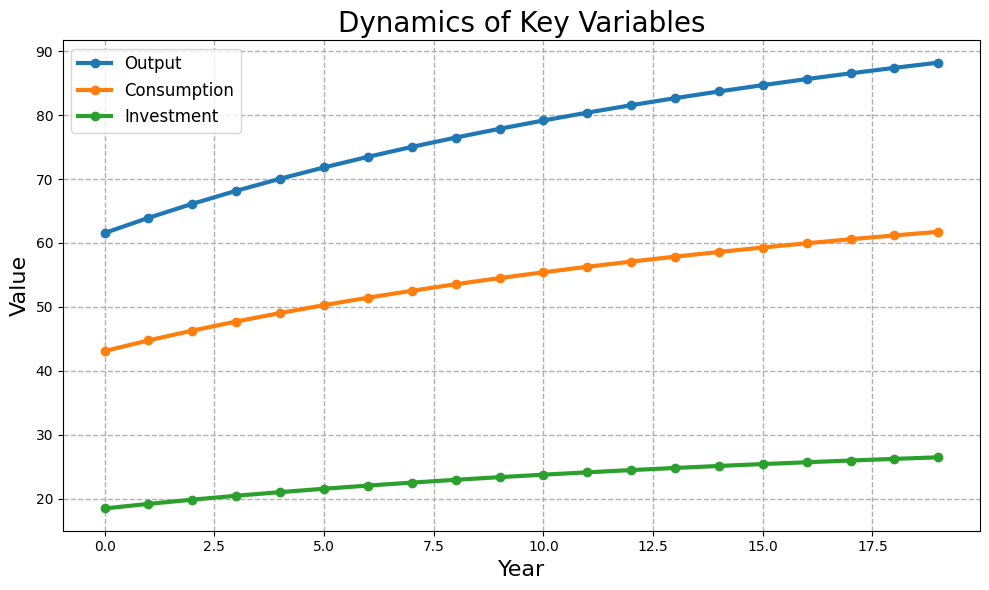

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV読み込み
df = pd.read_csv("../results/dcge_simulation.csv")

# 図1: 資本ストック推移（面積強調）
plt.figure(figsize=(10, 6))
plt.fill_between(df["Year"], df["Capital"], alpha=0.3)
plt.plot(df["Year"], df["Capital"], linewidth=4)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Capital Stock", fontsize=16)
plt.title("Capital Stock Path", fontsize=20)
plt.grid(True, linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig("../results/impact_capital.png", dpi=300)
plt.show()

# 図2: 生産・消費・投資の動態（マーカー付きライン）
plt.figure(figsize=(10, 6))
for col in ["Output", "Consumption", "Investment"]:
    plt.plot(df["Year"], df[col], linewidth=3, marker="o", markersize=6)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.title("Dynamics of Key Variables", fontsize=20)
plt.legend(["Output", "Consumption", "Investment"], fontsize=12)
plt.grid(True, linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig("../results/impact_dynamics.png", dpi=300)
plt.show()



In [13]:
import pandas as pd
import plotly.graph_objects as go

# SAMデータ読み込み（パスを必要に応じて調整）
sam = pd.read_csv("../data/sam_base.csv", index_col=0)

# ノードの順序を定義
nodes = [
    "Household", "Government", "Investment", "Imports", "Exports",
    "Agri", "Manu", "ValueAdded"
]

# リンク情報を抽出
sources, targets, values = [], [], []
for src in sam.columns:
    for tgt in sam.index:
        val = sam.loc[tgt, src]
        if val > 0:
            sources.append(nodes.index(src))
            targets.append(nodes.index(tgt))
            values.append(val)

# ノード座標を指定（産業と付加価値ノードのy座標をずらして交差を回避）
x_positions = [
    0.0, 0.0, 0.0, 0.0, 0.0,   # Household, Government, Investment, Imports, Exports
    0.65, 0.75, 0.85           # Agri, Manu, ValueAdded
]
y_positions = [
    0.8, 0.65, 0.5, 0.35, 0.2,  # 需要サイド（縦に並べる）
    0.7, 0.5, 0.3               # Agri（0.7）, Manu（0.5）, ValueAdded（0.3）
]

fig = go.Figure(data=[go.Sankey(
    arrangement='fixed',
    node=dict(
        label=nodes,
        x=x_positions,
        y=y_positions,
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="lightgrey"
    )
)])

fig.update_layout(
    title_text="Base-Year SAM Sankey Diagram\n(Separated Industry & VA Nodes)",
    font_size=12
)

# 保存＆表示
fig.write_image("../results/sankey_sam_separated.png", width=1000, height=600, scale=2)
fig.show()


In [9]:
import pandas as pd
import plotly.graph_objects as go

# ── 1. データ読み込み ──────────────────────────────────────────
sam = pd.read_csv("../data/sam_base.csv", index_col=0)

# ── 2. ノード定義 ─────────────────────────────────────────────
nodes = [
    "Household", "Government", "Investment", "Imports", "Exports",
    "Agri", "Manu", "ValueAdded"
]

# ── 3. リンク情報抽出 ─────────────────────────────────────────
sources, targets, values = [], [], []
for src in sam.columns:
    for tgt in sam.index:
        v = sam.loc[tgt, src]
        if v > 0:
            sources.append(nodes.index(src))
            targets.append(nodes.index(tgt))
            values.append(v)

# ── 4. ノード座標（ここだけを編集してください）──────────────────
x_positions = [
    0.0, 0.0, 0.0, 0.0, 0.0,   # Household, Government, Investment, Imports, Exports
    0.65, 0.75, 0.85          # Agri, Manu, ValueAdded
]
y_positions = [
    0.8, 0.65, 0.5, 0.35, 0.2,  # 需要サイド
    0.7, 0.5, 0.3               # Agri, Manu, ValueAdded
]

# ── 5. サンキー図作成 ─────────────────────────────────────────
fig = go.Figure(go.Sankey(
    arrangement='fixed',
    node=dict(
        label=nodes,
        x=x_positions,
        y=y_positions,
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="lightgrey"
    )
))

fig.update_layout(
    title="Base-Year SAM Sankey Diagram",
    font_size=12,
    width=900,
    height=600
)

# ── 6. 表示 ─────────────────────────────────────────────────
import plotly.io as pio

# どこからでも…  
pio.renderers.default = "browser"

# …図を出す  
fig.show()


## 技術進歩と外部ショック
- 技術進歩は「右肩上がりをさらに右上方向へ」シフトさせる  
- 外部ショックは「一時的な谷」を生み、回復力でその深さや長さが決まる

- results/capital_path_tech_shock.png
技術進歩あり ＋ ショックあり の資本ストック推移図

- results/dynamics_tech_shock.png
出力・消費・投資の動態図

- 主な追加ポイント
  - tech：年率ベースの技術成長率を掛け合わせて、生産量を上乗せ
  - shock_year／shock_factor：指定の年に資本を一時減少させる
  - ファイル名に _tech_shock を付け、以前のグラフ名と重複しないように出力

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def simulate_dcge_with_tech_shock(cons_share, inv_share, T=20, delta=0.05, alpha=0.3,
                                  tech=0.02, shock_year=None, shock_factor=1.0, K0=100.0, L=50.0):
    """
    cons_share: dict, commodity->consumption share
    inv_share: float, investment share
    tech: float, annual technology growth rate (e.g. 0.02 for 2%)
    shock_year: int or None, year at which to apply shock
    shock_factor: float, multiplier on capital at shock (e.g. 0.8 keeps 80%)
    """
    years = list(range(T + 1))
    K_path, Y_path, C_path, I_path = [K0], [], [], []

    for t in range(T):
        K = K_path[-1]
        # Apply external shock at start of shock_year
        if shock_year is not None and t == shock_year:
            K = K * shock_factor

        # Production with technology growth
        tech_multiplier = (1 + tech) ** t
        Y = (K ** alpha) * (L ** (1 - alpha)) * tech_multiplier

        # Investment and consumption
        I = inv_share * Y
        C = (1 - inv_share) * Y

        # Record values
        Y_path.append(Y)
        I_path.append(I)
        C_path.append(C)

        # Capital accumulation
        K_next = (1 - delta) * K + I
        K_path.append(K_next)

    df = pd.DataFrame({
        "Year": years[:-1],
        "Output": Y_path,
        "Consumption": C_path,
        "Investment": I_path,
        "Capital": K_path[:-1],
    })
    return df

# Example usage
if __name__ == "__main__":
    # Calibration parameters
    cons_share = {"Agri": 0.444, "Manu": 0.556}
    inv_share = 0.25

    # Simulate with 5% tech growth and a shock in year 10 reducing capital to 80%
    df = simulate_dcge_with_tech_shock(cons_share, inv_share, T=20,
                                       delta=0.05, alpha=0.3,
                                       tech=0.05, shock_year=10, shock_factor=0.8,
                                       K0=100, L=50)

    # Prepare output folder
    outdir = "../results"
    os.makedirs(outdir, exist_ok=True)

    # Plot capital path
    plt.figure(figsize=(8, 5))
    plt.plot(df["Year"], df["Capital"], linewidth=3)
    plt.title("Capital Stock Path with Tech Growth & Shock", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Capital", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    cap_file = os.path.join(outdir, "capital_path_tech_shock.png")
    plt.savefig(cap_file, dpi=200)
    plt.close()

    # Plot dynamics
    plt.figure(figsize=(8, 5))
    for col in ["Output", "Consumption", "Investment"]:
        plt.plot(df["Year"], df[col], linewidth=2, marker="o", markersize=5)
    plt.title("Output, Consumption, Investment\nwith Tech Growth & Shock", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend(["Output", "Consumption", "Investment"], fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    dyn_file = os.path.join(outdir, "dynamics_tech_shock.png")
    plt.savefig(dyn_file, dpi=200)
    plt.close()

    print(f"Saved capital path to {cap_file}")
    print(f"Saved dynamics to {dyn_file}")


Saved capital path to ../results\capital_path_tech_shock.png
Saved dynamics to ../results\dynamics_tech_shock.png
